In [11]:
# Carrega todas as colunas e garante uma chave estável

import pandas as pd

df = pd.read_csv("../../data/raw/tccs.csv")

assert "resumo" in df.columns, "A coluna 'resumo' não existe no CSV."

# DOC_ID estável para cruzamentos
if "DOC_ID" not in df.columns:
    df.insert(0, "DOC_ID", range(len(df)))

print("Shape:", df.shape, "| colunas (10 primeiras):", list(df.columns)[:10], "...")

Shape: (423, 7) | colunas (10 primeiras): ['DOC_ID', 'ano', 'titulo', 'autor', 'orientador', 'resumo', 'url'] ...


In [12]:
# Configuração spaCy + stopwords (apenas nativas do spaCy)

import spacy, unidecode
from spacy.lang.pt.stop_words import STOP_WORDS

# Modelo PT do spaCy
nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser"])

# Normaliza as stopwords para o mesmo espaço dos lemas
stopwords_norm = {unidecode.unidecode(w.lower()) for w in STOP_WORDS}
print("Stopwords (spaCy) normalizadas:", len(stopwords_norm))

Stopwords (spaCy) normalizadas: 403


In [13]:
# Funções de normalização e lematização (preserva acentos até lematizar)

def normalize_text_lower(s: str) -> str:
    return s.lower()

def tokenize_lemmatize(text: str):
    doc = nlp(text)
    toks = []
    for t in doc:
        if not t.is_alpha:
            continue
        lemma_str = unidecode.unidecode(t.lemma_.lower()).strip()
        for sub in lemma_str.split():
            if len(sub) <= 2 or sub in stopwords_norm:
                continue
            toks.append(sub)
    return toks


In [14]:
# Aplicação nos resumos

resumos_lower = df["resumo"].fillna("").astype(str).map(normalize_text_lower)
docs_tokens = [tokenize_lemmatize(t) for t in resumos_lower]

print("Exemplo original:\n", df["resumo"].iloc[0])
print("\nApós processamento (30 primeiros tokens):\n", docs_tokens[0][:30])

Exemplo original:
 Gerenciar a agenda e fornecer informações ao cliente são tarefas que oneram muito o tempo do pequeno empreendedor, que, em muitos casos, gerencia e opera um negócio sozinho, precisando maximizar seu tempo produzindo para obter melhores resultados e manter o seu empreendimento em atividade. Este trabalho tem como objetivo propor o desenvolvimento de um sistema web que oferece ao empreendedor um meio de fornecer as principais informações sobre seu negócio e visualizar os serviços agendados. O sistema provê ao consumidor dos serviços prestados uma forma de visualizar as informações sobre um determinado serviço e efetuar o agendamento em horário disponível e conveniente para si, dispensando a necessidade de qualquer tipo de contato prévio com o prestador do serviço. A solução foi avaliada por 23 usuários, obtendo um índice de satisfação médio de 4.7 entre os dois grupos de usuários (prestadores de serviços e consumidores), constatando ser uma proposta eficaz na solução d

In [15]:
# Bigramas com Gensim Phrases

from gensim.models.phrases import Phrases, Phraser

MIN_COUNT = 5
THRESHOLD = 10.0

phrases = Phrases(docs_tokens, min_count=MIN_COUNT, threshold=THRESHOLD, delimiter="_")
bigram_phraser = Phraser(phrases)

# Aplica o detector de bigramas
docs_tokens = [bigram_phraser[doc] for doc in docs_tokens]
print("Bigramas aplicados.")

Bigramas aplicados.


In [16]:
# Checagem dos n-gramas aprendidos

# Inspeciona quantos tokens com "_" surgiram e mostra exemplos
tokens_flat = [tok for doc in docs_tokens for tok in doc]
ngrams = [t for t in tokens_flat if "_" in t]
print("Total de tokens:", len(tokens_flat))
print("Total de n-gramas (com '_'):", len(ngrams))
print("Exemplos:", ngrams[:20])


Total de tokens: 32892
Total de n-gramas (com '_'): 1334
Exemplos: ['fornecer_informacao', 'trabalho_objetivo', 'desafio_significativo', 'aprendizado_maquina', 'contribuir_avanco', 'rede_neural', 'resultado_indicar', 'presente_trabalho', 'tomar_decisao', 'estudo_investigar', 'modelo_linguagem', 'linguagem_programacao', 'desenvolvimento_software', 'desenvolvimento_software', 'processo_desenvolvimento', 'fornecer_informacao', 'processo_desenvolvimento', 'desafio_significativo', 'isolamento_social', 'apresentar_solucao']


In [17]:
# Salva o modelo de bigramas para reuso

import os
BIGRAM_PATH = "../../data/interim/lda/bigram_phraser.pkl"
os.makedirs(os.path.dirname(BIGRAM_PATH), exist_ok=True)
bigram_phraser.save(BIGRAM_PATH)
print("Bigram phraser salvo em:", BIGRAM_PATH)

Bigram phraser salvo em: ../../data/interim/lda/bigram_phraser.pkl


In [18]:
# Salvando resultado (mantém todas as colunas + RESUMO_PREP)

import os, pickle

df["RESUMO_PREP"] = [" ".join(t) for t in docs_tokens]

OUT_CSV = "../../data/interim/lda/prep.csv"
OUT_TOKENS = "../../data/interim/lda/tokens.pkl"

os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)

df.to_csv(OUT_CSV, index=False)

with open(OUT_TOKENS, "wb") as f:
    pickle.dump(docs_tokens, f)

print("OK ->", OUT_CSV, "| docs:", len(df), "| colunas:", len(df.columns))
print("Tokens salvos em:", OUT_TOKENS, "| docs_tokens:", len(docs_tokens))

OK -> ../../data/interim/lda/prep.csv | docs: 423 | colunas: 8
Tokens salvos em: ../../data/interim/lda/tokens.pkl | docs_tokens: 423


Tabela (RAW) salva em: ..\..\data\interim\quality\vocab_freq_raw_top.png
Tabela (PÓS) salva em: ..\..\data\interim\quality\vocab_freq_preprocessed_top.png


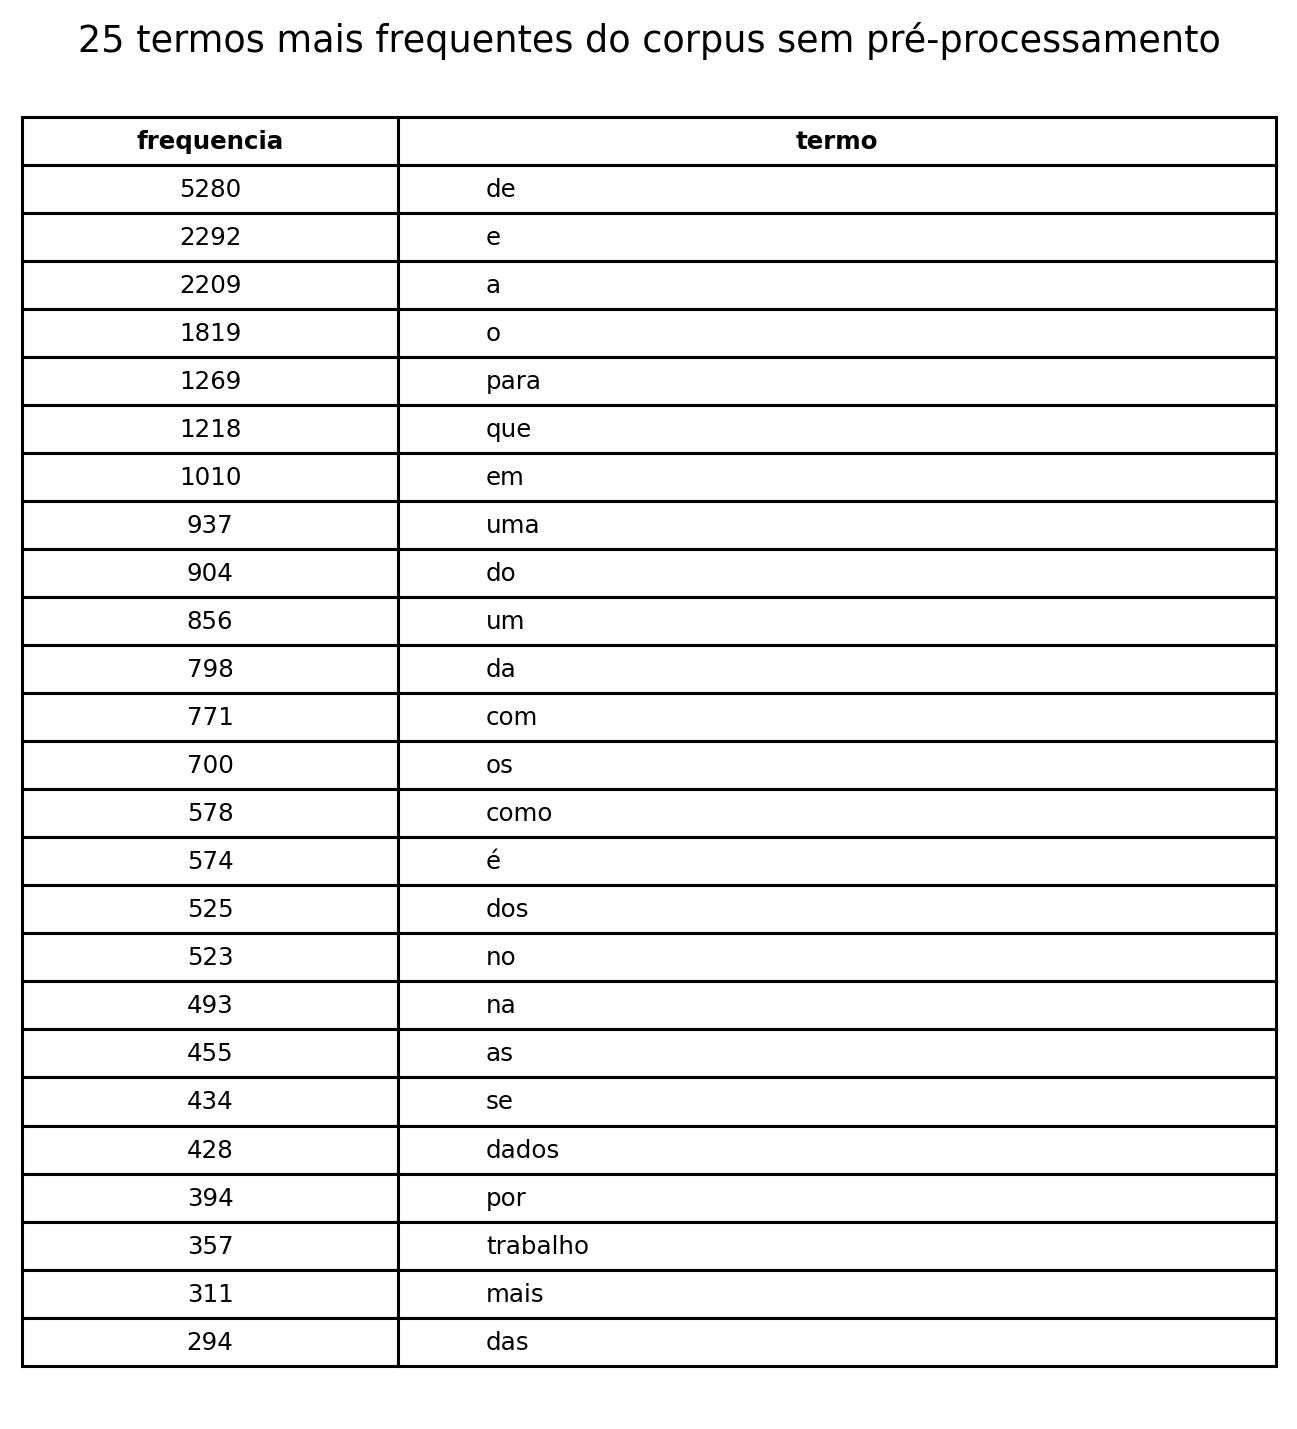

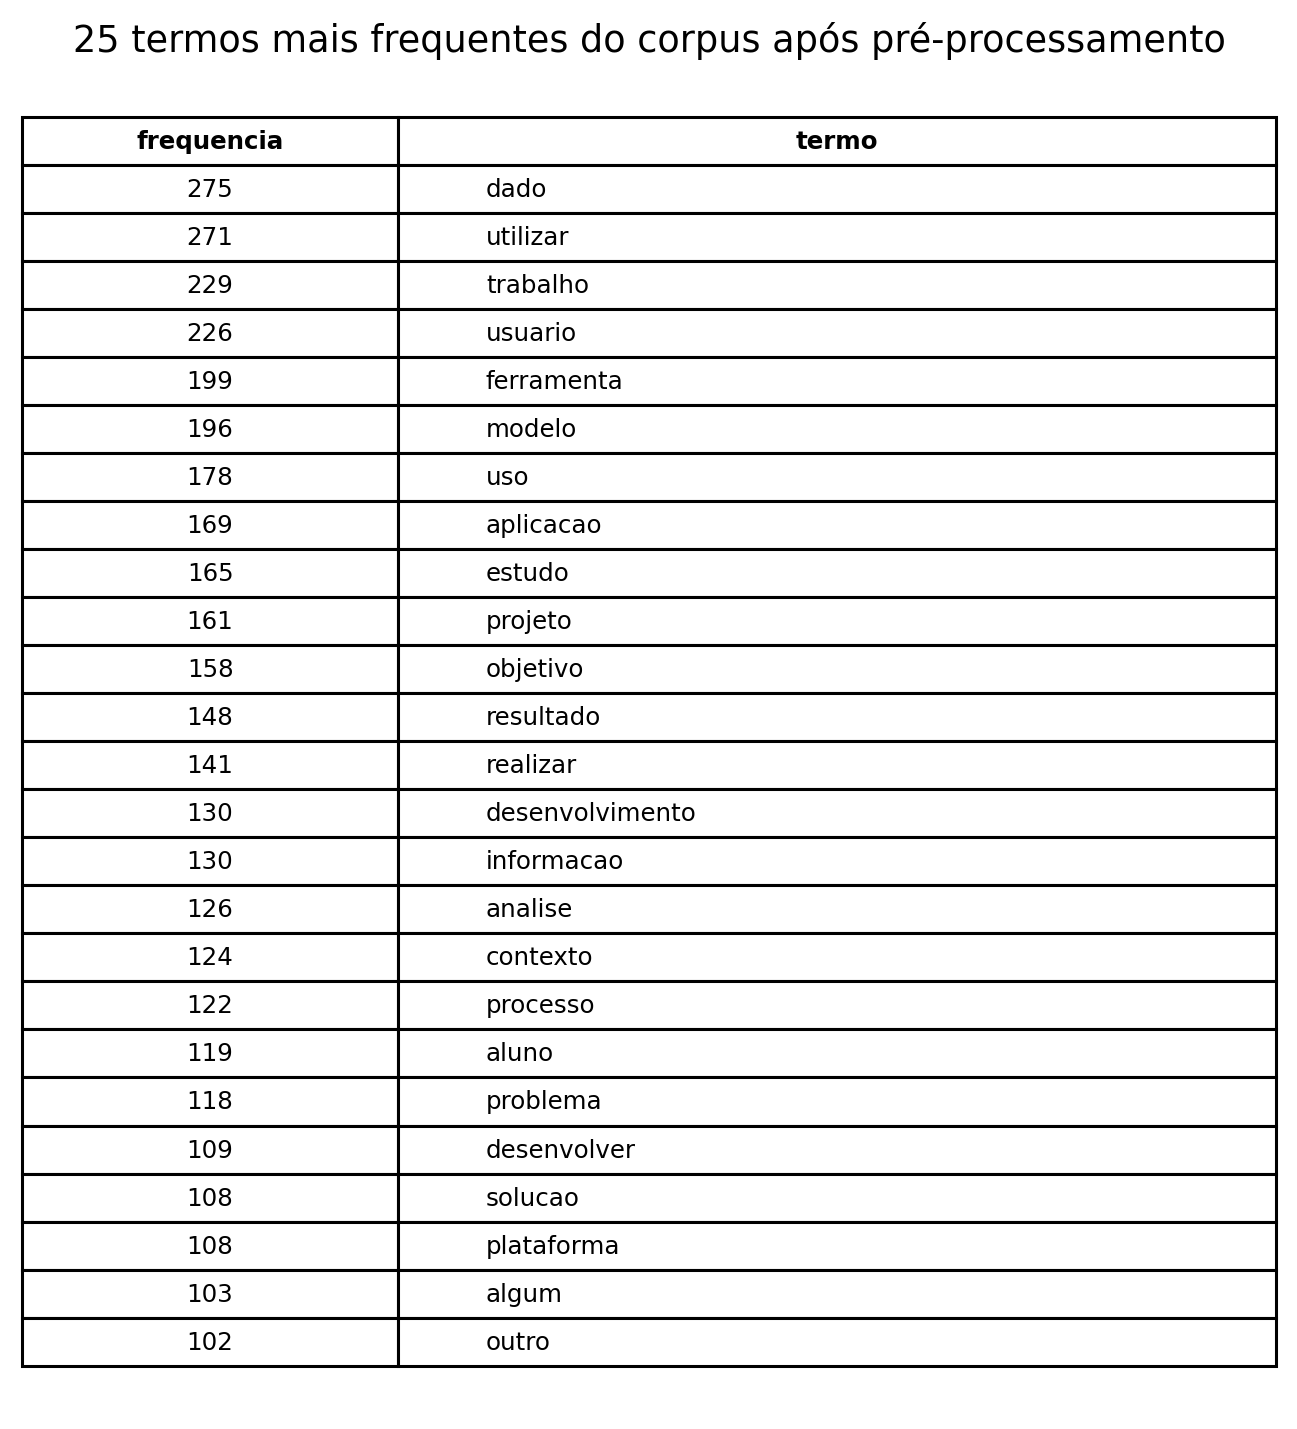

In [ ]:
# --- Tabelas (PNG): termos mais frequentes ANTES (RAW) vs DEPOIS (pré-processamento) ---
# Salva:
#   ../../data/interim/quality/vocab_freq_raw_top.png
#   ../../data/interim/quality/vocab_freq_preprocessed_top.png

from pathlib import Path
import re
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

OUT_DIR = Path("../../data/interim/quality")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------
# Utilitários
# -------------------------------
def has_letter(token: str) -> bool:
    return bool(re.search(r"[A-Za-zÀ-ÖØ-öø-ÿ]", token))

def tokenize_raw(text: str) -> list[str]:
    if not isinstance(text, str):
        return []
    t = text.lower()
    toks = re.findall(r"\w+", t, flags=re.UNICODE)
    return [tok for tok in toks if has_letter(tok)]

def save_table_image(
    df: pd.DataFrame,
    title: str,
    out_path: Path,
    *,
    width_inches: float = 6.0,     # ↓ diminua para deixar mais estreita (ex.: 5.5, 5.0)
    height_per_row: float = 0.24,  # altura por linha
    font_size: int = 8,            # fonte menor ajuda a compactar
    col_widths=(0.30, 0.70)        # proporção de largura entre as 2 colunas
):
    """Renderiza df (colunas: 'frequencia', 'termo') como PNG mais estreito."""
    import matplotlib.pyplot as plt

    n_rows = len(df)
    fig_h = 0.6 + height_per_row * max(n_rows, 1)   # altura dinâmica
    fig_w = width_inches                             # largura controlada
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=220)
    ax.axis("off")
    ax.set_title(title, pad=8)

    tbl = ax.table(
        cellText=df.values.tolist(),
        colLabels=list(df.columns),
        loc="center",
        colWidths=col_widths
    )

    # Estilo/compactação
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1.0, 1.1)  # menos expansão vertical

    # Cabeçalho em negrito + alinhamentos
    for (r, c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold", ha="center", va="center")
        else:
            if c == 0:  # frequencia
                cell.set_text_props(ha="center", va="center")
            else:       # termo
                cell.set_text_props(ha="left", va="center")
        # tentativa de wrap
        try:
            cell.get_text().set_wrap(True)
        except Exception:
            pass

    fig.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)



def _pick_text_series(df: pd.DataFrame) -> pd.Series:
    # tenta 'resumo' depois 'abstract'/'summary'
    for cand in ("resumo", "abstract", "summary"):
        if cand in df.columns:
            return df[cand].fillna("").astype(str)
    # fallback: primeira coluna string-like com >0 não vazios
    for c in df.columns:
        s = df[c].astype(str)
        if (s.str.len().gt(0)).mean() > 0.5:
            return s.fillna("").astype(str)
    raise ValueError("Nenhuma coluna de texto encontrada.")

# -------------------------------
# Fonte dos textos RAW
#   - Se 'df' existe no ambiente e tem coluna de texto, usa-o.
#   - Caso contrário (ex.: 02_vocab_bow), lê ../../data/raw/tccs.csv.
# -------------------------------
try:
    assert 'df' in globals()
    texts_raw = _pick_text_series(df)
except Exception:
    raw_csv = Path("../../data/raw/tccs.csv")
    assert raw_csv.exists(), f"CSV não encontrado: {raw_csv}"
    _df_raw = pd.read_csv(raw_csv, encoding="utf-8")
    texts_raw = _pick_text_series(_df_raw)

# -------------------------------
# Vetor de tokens pós-processados
#   - 01_prep: docs_tokens
#   - 02_vocab_bow: docs_list (ajuste automático abaixo)
# -------------------------------
if 'docs_tokens' in globals():
    _docs = docs_tokens
elif 'docs_list' in globals():
    _docs = docs_list
else:
    raise AssertionError("Não encontrei 'docs_tokens' (01_prep) nem 'docs_list' (02_vocab_bow).")

TOP_N = 25  # ajuste conforme desejar

# -------------------------------
# Tabela 1 — RAW (antes)
# -------------------------------
raw_counter = Counter()
for txt in texts_raw:
    raw_counter.update(tokenize_raw(txt))
df_raw = pd.DataFrame(raw_counter.most_common(TOP_N), columns=["termo", "frequencia"])[["frequencia", "termo"]]
png_raw = OUT_DIR / "vocab_freq_raw_top.png"
save_table_image(df_raw,  f"{TOP_N} termos mais frequentes do corpus sem pré-processamento da LDA",
                 png_raw, width_inches=6.0, font_size=8)
print("Tabela (RAW) salva em:", png_raw)

# -------------------------------
# Tabela 2 — DEPOIS (pós-processamento)
# -------------------------------
clean_counter = Counter(tok for doc in _docs for tok in doc)
df_clean = pd.DataFrame(clean_counter.most_common(TOP_N), columns=["termo", "frequencia"])[["frequencia", "termo"]]
png_clean = OUT_DIR / "vocab_freq_preprocessed_top.png"
save_table_image(df_clean, f"{TOP_N} termos mais frequentes do corpus após pré-processamento da LDA",
                 png_clean, width_inches=6.0, font_size=8)
print("Tabela (PÓS) salva em:", png_clean)

# Exibe ambas
from IPython.display import Image, display
display(Image(filename=str(png_raw)))
display(Image(filename=str(png_clean)))


In [ ]:
# Checagem de sanidade

from collections import Counter

lens = [len(d) for d in docs_tokens]
print(f"Docs: {len(docs_tokens)} | tokens/doc (min/med/ max): {min(lens)}/{sorted(lens)[len(lens)//2]}/{max(lens)}")
vocab = Counter(tok for d in docs_tokens for tok in d)
print("Top 15 tokens:", [w for w,_ in vocab.most_common(15)])